In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import copy
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn import model_selection as ms
from sklearn import linear_model as lm

# Evaluating the performance of pair trading two commodities (Brent Oil and WTI Oil)

##Pair Trading is similar to a mean reversion strategy. Here we assume that the assets should fluctuate around an "equillibrium" spread/difference.

##Consider Google and Apple: This means that if google rockets up in price and Apple doesn't, we expect *over time* **either** Google will come back down or Apple will go up (either way the pair's spread or difference will return back to equillibrium) or **both!**

##Therefore, there will be a combination of the pair of assets that is stationary and mean reverting - the combination doesn't have to be (and often isn't) 1 Google for 1 Apple.

##To understand this strategy in greater detail look here:

##https://hudsonthames.org/definitive-guide-to-pairs-trading/

In [2]:
#Import Data from yfinance

asset_1 = 'CL=F' #Crude Oil
asset_2 = 'BZ=F' #Brent Oil
tickers = [asset_1, asset_2]

start_date = datetime(2007, 1, 1)
end_date = datetime(2020, 1, 1)

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna()
data = data.rename(columns={'BZ=F': 'Crude Oil', 'CL=F': 'Brent Oil'})
train, test = ms.train_test_split(data, shuffle = False, test_size = 0.2)
print(data.head())


[*********************100%%**********************]  2 of 2 completed
            Crude Oil  Brent Oil
Date                            
2007-07-30  75.739998  76.830002
2007-07-31  77.050003  78.209999
2007-08-01  75.349998  76.529999
2007-08-02  75.760002  76.860001
2007-08-03  74.750000  75.480003


# Plot the train part of the two time series and plot a heatmap / print their correlation (2 Marks)

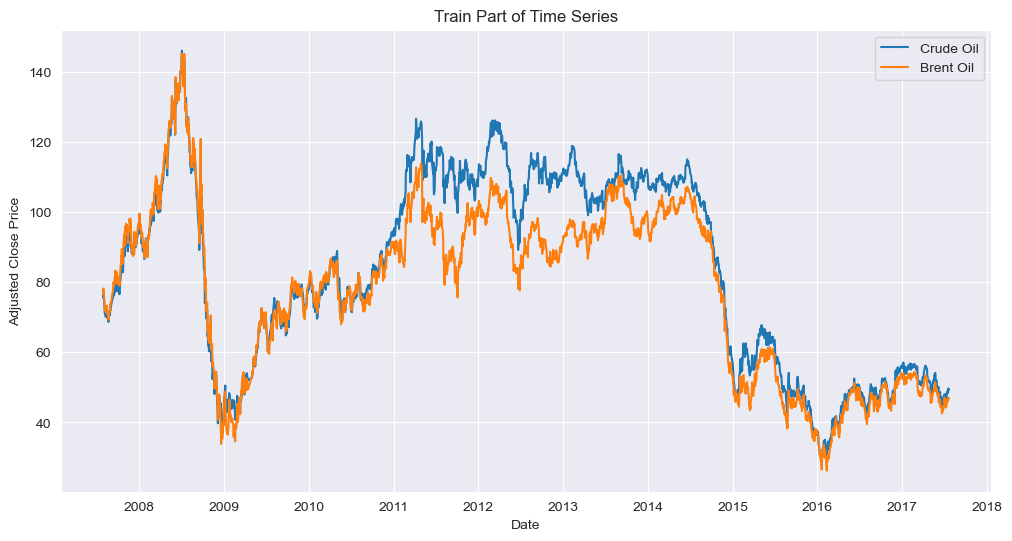

In [3]:
#Plot it here
# Plotting the train part of the two time series
plt.figure(figsize=(12, 6))
plt.plot(train["Crude Oil"], label="Crude Oil")
plt.plot(train["Brent Oil"], label="Brent Oil")
plt.title('Train Part of Time Series')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

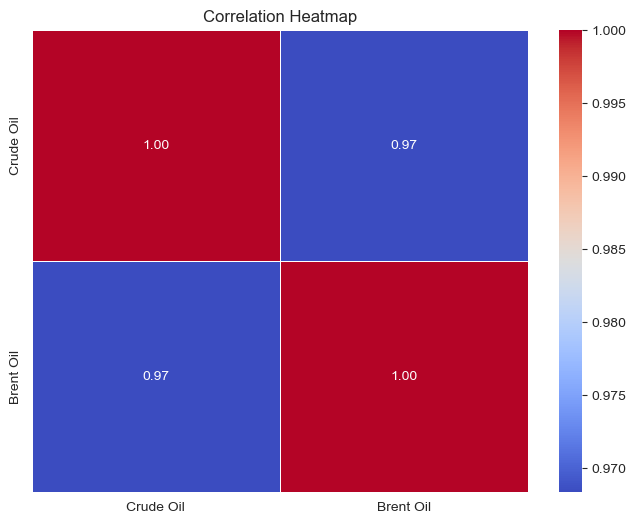

In [4]:
# Creating a heatmap of the correlation
correlation_matrix = train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
print("Correlation between Crude Oil and Brent Oil is 0.97")

Correlation between Crude Oil and Brent Oil is 0.97


# Linear Regression (2 Marks)

## Plot the value of X against the value of Y - we want to find the sensitivity of Y when X changes by 1 dollar (sometimes called the hedging ratio: https://robotwealth.com/practical-pairs-trading/#:~:text=In%20pairs%20trading%2C%20that%20coefficient,depending%20on%20the%20approach%20taken.)

## We will buy a ratio of gradient X per Y bought so that overall, if they were perfectly linearly related, our overall position would never make or lose any money.

## Regress X against y to find our gradient (hedging ratio) and the intercept. After you've done this update the data below with your values/variables (do not delete the LHS): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

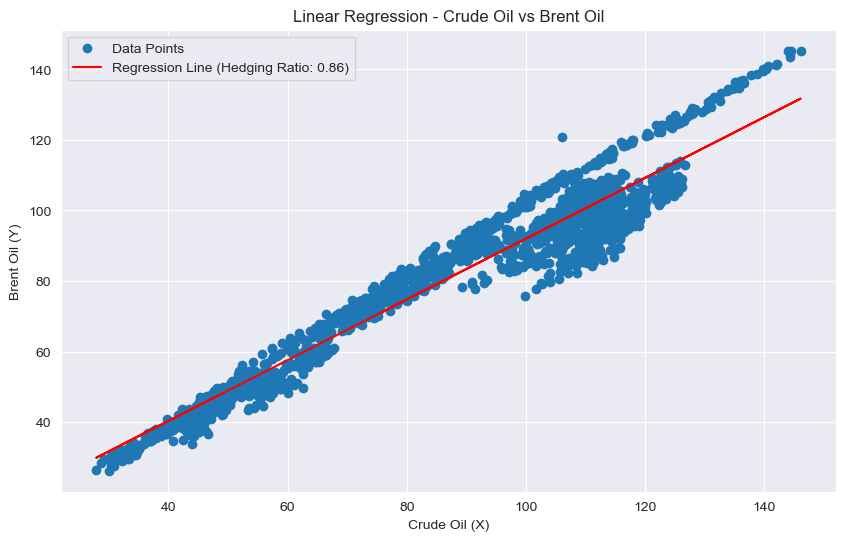

In [6]:
#Calculate it here


# Extract X and Y from the training set
X = train['Crude Oil'].values.reshape(-1, 1)  # Reshape to a 2D array
Y = train['Brent Oil'].values

# Perform linear regression
regression_model = lm.LinearRegression()
regression_model.fit(X, Y)

# Get the coefficients (hedging ratio) and intercept
hedging_ratio = regression_model.coef_[0]
intercept = regression_model.intercept_
r2_coefficient = regression_model.score(X, Y)

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Data Points')
plt.plot(X, regression_model.predict(X), color='red', label=f'Regression Line (Hedging Ratio: {hedging_ratio:.2f})')
plt.title('Linear Regression - Crude Oil vs Brent Oil')
plt.xlabel('Crude Oil (X)')
plt.ylabel('Brent Oil (Y)')
plt.legend()
plt.show()

In [7]:
#Don't delete/change these variable names just replace the None's
R2_coeff = r2_coefficient
gradient = hedging_ratio
intercept = intercept

print("R^2 Coefficient: ", R2_coeff)
print("Gradient: ", gradient)
print("Intercept: ", intercept)

R^2 Coefficient:  0.9376630295639481
Gradient:  0.8616920272432642
Intercept:  5.853920228183313


# Compute the Residual (on train) and Plot it (1 mark)

## Given a new value for X and Y, we can now make a prediction of Y based on X using our Linear Regression model, then calculate the residual between our prediction and the actual value.

## Calculating all the residuals for the training data will generate a distribution that will tell us the mean (equilibrium) and std values. This is how we will generate signals later.


## residual = y - pred(Y)
## pred(Y) = m X + c

In [8]:
predicted_Y = regression_model.predict(X)
residuals = Y - predicted_Y

In [9]:
print(residuals)

[ 5.7115293   5.96270553  5.74758561 ... -1.53895744 -1.56001571
 -1.5453356 ]


-4.997223636114991e-15


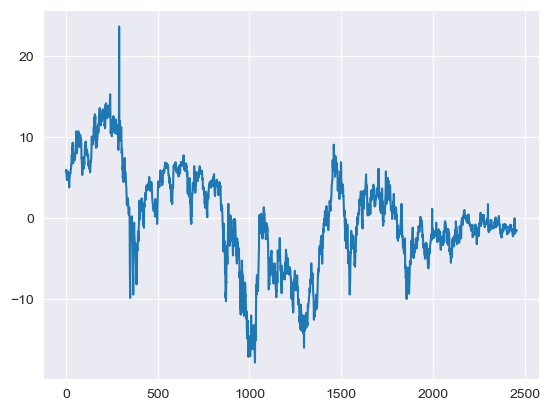

In [10]:
train_residual = residuals
print(train_residual.mean())
plt.plot(train_residual)
plt.show()

#Vibe Check - Stationarity Test for the Residual (1 Mark)

## If the pair are truly "cointegrated" then their residue should be stationary. There are a bunch of statistical tests to *investigate* whether the residue is stationary, but a standard one is the augmented dickie fuller (ADF): https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

## Check out the docs and perform the adfuller test with a maxlag of 0. spit out the p-value (note if you can't work this out **unlike the other steps** it won't affect your final results).

In [11]:
adf_test_result = adfuller(train_residual, maxlag=0)

In [12]:
p_value = adf_test_result[1]
print("P value:", p_value)

P value: 0.006665664371704799


# Convert the (train) residue to a standard normal (mean of 0, std of 1) (1 mark)

## This is always done just as good practice.

## X = (x-mean(x))/std(x)

In [13]:
standardized_residuals = (train_residual - train_residual.mean()) / train_residual.std()

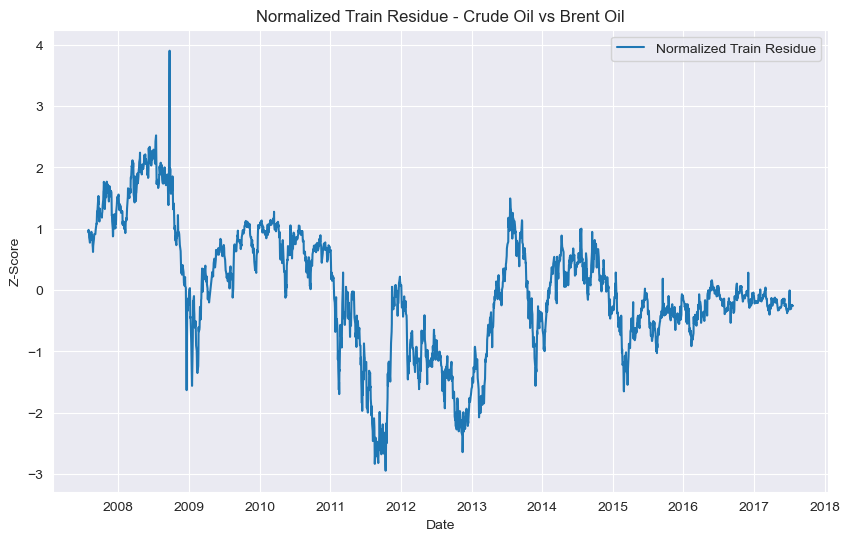

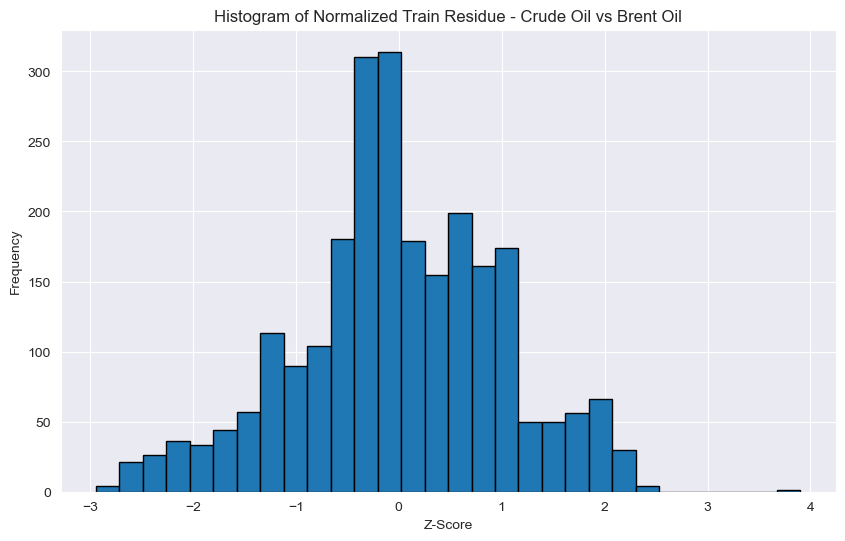

In [14]:
#Insert the normalised train residue below:

train_z_score = standardized_residuals

# Plot the normalized train residue
plt.figure(figsize=(10, 6))
plt.plot(train.index, train_z_score, label='Normalized Train Residue')
plt.title('Normalized Train Residue - Crude Oil vs Brent Oil')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()

# Plot the histogram of the normalized train residue
plt.figure(figsize=(10, 6))
plt.hist(train_z_score, bins=30, edgecolor='black')
plt.title('Histogram of Normalized Train Residue - Crude Oil vs Brent Oil')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Signal Weightings

## These are a bit funky, we have 2 signal types.

## **Basic Signal:** One is a simple "whenever the two assets difference is more than 1 sigma away from its historic 'equillibrium', we bet on the residue returning to less than one sigma" (go short or long depending on whether the residue is ±). We cash out when the residue hits 0, and hold in the mean time.

## **Tanh Signal:** The second signal type is a bit weirder, the idea is that we enter at 0.5 sigma, but as the pair continue to dislocate in price (the spread widens + the residue increases in magnitude) we go continually more long/short, we don't wind down our trade until the spread returns to a sigma of 0.5 at which point we close the trade.

## This second signal method isn't random. The motivation for this type of signal is that as an event becomes more stasticially significant (and the trade becomes more appealing) we increase the size of the trade.

## *Sometimes this is taken a step further by adding an exponential decay factor to start winding down the position if the spread gets way too big and we lose confidence in the trade.*

### Apologies for the scrappy code but you can see how both signals work below - they both have parameters which change the signal + therefore the pnl of the strategy

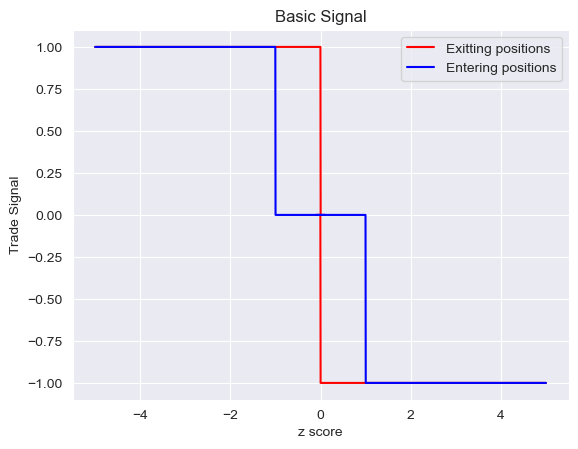

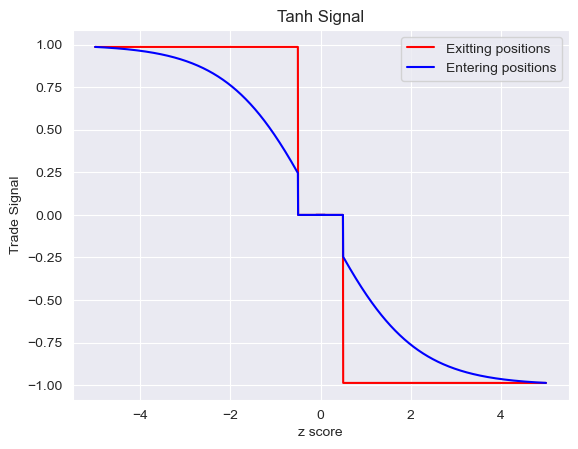

In [15]:
x_scores_entering = np.linspace(.1, -5, 1000)
x_scores_entering_2 = np.linspace(-.1, 5, 1000)
x_scores_exitting = np.linspace(-5, .1, 1000)
x_scores_exitting_2 = np.linspace(5, -.1, 1000)


def basic_signal(z_score_array, z_score_trigger_in = 1, z_score_trigger_out = 0):
  signal = np.zeros(len(z_score_array))
  entered_long = False
  entered_short = False

  for i, element in enumerate(z_score_array):

    if not entered_long and not entered_short and element > z_score_trigger_in:
        signal[i] = -1
        entered_short = True

    elif not entered_long and not entered_short and element < -z_score_trigger_in:
      signal[i] = 1
      entered_long = True

    elif element > -z_score_trigger_out and entered_long:
      signal[i] = 0
      entered_long = False

    elif element < z_score_trigger_out and entered_short:
      signal[i] = 0
      entered_short = False

    else:
      if i == 0:
        signal[i] = 0
      else:
        signal[i] = signal[i-1]

  return signal

# plt.plot(x_scores, basic_signal(x_scores), label = "Entering positions")

plt.plot(x_scores_exitting, basic_signal(x_scores_exitting), label = "Exitting positions",c =  "r")
plt.plot(x_scores_exitting_2, basic_signal(x_scores_exitting_2), c = "r")
plt.plot(x_scores_entering, basic_signal(x_scores_entering), label = "Entering positions",c =  "b")
plt.plot(x_scores_entering_2, basic_signal(x_scores_entering_2), c = "b")
plt.xlabel("z score")
plt.ylabel("Trade Signal")
plt.legend()
plt.title("Basic Signal")
plt.show()



def tanh_signal(z_score_array, z_score_scaling = 2, z_score_trigger = 0.5):
  signal = np.zeros(len(z_score_array))
  entered_long = False
  entered_short = False
  for i, element in enumerate(z_score_array):
    if not entered_long and not entered_short and element > z_score_trigger:
        signal[i] = -np.tanh(element/z_score_scaling)
        entered_short = True

    elif not entered_long and not entered_short and element < -z_score_trigger:
      signal[i] = -np.tanh(element/z_score_scaling)
      entered_long = True

    elif element > -z_score_trigger and entered_long:
      signal[i] = 0
      entered_long = False

    elif element < z_score_trigger and entered_short:
      signal[i] = 0
      entered_short = False

    else:
      if i == 0:
        signal[i] = 0
      elif entered_short:
        signal[i] = min([signal[i-1], -np.tanh(element/z_score_scaling)])
      elif entered_long:
        signal[i] = max([signal[i-1], -np.tanh(element/z_score_scaling)])
      else:
        signal[i] = 0

  return signal


plt.plot(x_scores_exitting, tanh_signal(x_scores_exitting), label = "Exitting positions",c =  "r")
plt.plot(x_scores_exitting_2, tanh_signal(x_scores_exitting_2), c = "r")
plt.plot(x_scores_entering, tanh_signal(x_scores_entering), label = "Entering positions",c =  "b")
plt.plot(x_scores_entering_2, tanh_signal(x_scores_entering_2), c = "b")
plt.xlabel("z score")
plt.legend()
plt.ylabel("Trade Signal")
plt.title("Tanh Signal")
plt.show()

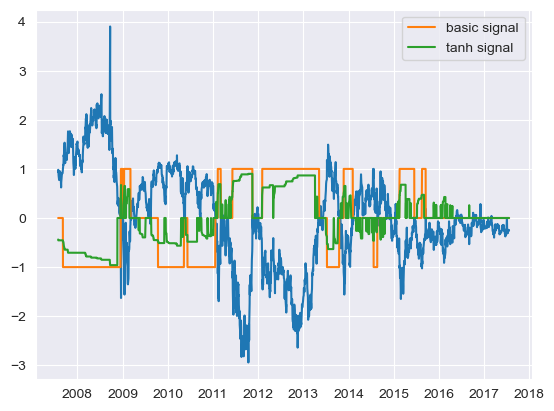

In [16]:
plt.plot(train.index, train_z_score)
plt.plot(train.index, basic_signal(train_z_score), label = "basic signal")
plt.plot(train.index, tanh_signal(train_z_score), label = "tanh signal")
plt.legend()
plt.show()

#Backtest Functions + Strategy Assessment

## **backtest** Here are a couple more freebie functions, the first is a backtest function that takes in a pair of time series, and the trade signal generated each day (without shifting - in practice we have to shift the signal by 1 so that day 1's signal affects the returns of the strategy on day1->day2).

##It also has an optional parameter *cumulative_returns* which when True, shows how much money you'd make on $100 historically with this strategy, or returns the daily % pnl if False.

## **create_test_zscores** Here are a couple more freebie functions, the first is a backtest function that takes in a pair of time series, and the trade signal generated each day (without shifting - in practice we have to shift the signal by 1 so that day 1's signal affects the returns of the strategy on day1->day2).

##It also has an optional parameter *cumulative_returns* which, if True, shows how much money you'd make on $100 historically with this strategy (with compounding), or returns the daily % pnl if False.

## **calc_sharpe** This computes the sharpe ratio (with a r.f.r of 0 (dubious I know)) but allows you to compare the risk adjusted return of the two strategies. You should input the daily_percent_returns without compounding (*cumulative_returns* = False)

In [17]:
def backtest(pair_time_series, unshifted_signal, cumulative_returns = True):
  asset_1 = pair_time_series.iloc[:,0]
  asset_2 = pair_time_series.iloc[:,1]

  change_in_price_asset_1 = asset_1.diff()
  change_in_price_asset_1[0] = 0
  change_in_price_asset_2 = asset_2.diff()
  change_in_price_asset_2[0] = 0

  signal_asset_1 = -unshifted_signal*gradient
  signal_asset_2 = unshifted_signal

  shifted_signal_asset_1 = np.roll(signal_asset_1,1)
  shifted_signal_asset_1[0] = 0


  shifted_signal_asset_2 = np.roll(signal_asset_2,1)
  shifted_signal_asset_2[0] = 0


  daily_returns_asset_1 = change_in_price_asset_1*shifted_signal_asset_1
  daily_returns_asset_2 = change_in_price_asset_2*shifted_signal_asset_2

  daily_returns = daily_returns_asset_1 + daily_returns_asset_2

  total_holdings = asset_1 + asset_2/gradient

  daily_percentage_returns = daily_returns/total_holdings

  if cumulative_returns:
    cumulative_pct_returns = 100*np.cumprod(1+daily_percentage_returns)
    return cumulative_pct_returns

  else:
    return daily_percentage_returns

def create_test_z_scores(pair_time_series = test):
  asset_1 = pair_time_series.iloc[:,0]
  asset_2 = pair_time_series.iloc[:,1]

  residual = asset_2 - (gradient*asset_1+intercept)

  test_z_score = (residual - train_residual.mean())/train_residual.std()

  return test_z_score

def calc_sharpe(non_cumulative_return_time_series):
  mean_daily_return = np.mean(non_cumulative_return_time_series)
  mean_yearly_return = 252*mean_daily_return
  volatility_of_returns = np.std(non_cumulative_return_time_series)
  print(mean_yearly_return, volatility_of_returns)
  return (mean_yearly_return)/(np.sqrt(252)*volatility_of_returns)


# Strategy Comparison (1 mark)

##Using the functions provided, assess the performance of both the Basic & Tanh strategies **for the train portion of our dataset** (train), which strategy is better and why? Is this still true on the test data

In [18]:
# Define parameters for signals
z_score_trigger_in = 1
z_score_trigger_out = 0
z_score_scaling_tanh = 2
z_score_trigger_tanh = 0.5

# Generate signals for both strategies on the train set
basic_signal_train = basic_signal(train_z_score, z_score_trigger_in, z_score_trigger_out)
tanh_signal_train = tanh_signal(train_z_score, z_score_scaling_tanh, z_score_trigger_tanh)

# Backtest both strategies on the train set
cumulative_returns_basic = backtest(train, basic_signal_train)
cumulative_returns_tanh = backtest(train, tanh_signal_train)

# Calculate Sharpe ratios for both strategies
sharpe_basic = calc_sharpe(backtest(train, basic_signal_train, cumulative_returns=False))
sharpe_tanh = calc_sharpe(backtest(train, tanh_signal_train, cumulative_returns=False))

# Print results
print("Cumulative Returns - Basic Strategy:", cumulative_returns_basic.iloc[-1])
print("Cumulative Returns - Tanh Strategy:", cumulative_returns_tanh.iloc[-1])
print("Sharpe Ratio - Basic Strategy:", sharpe_basic)
print("Sharpe Ratio - Tanh Strategy:", sharpe_tanh)

0.06853703133993815 0.0044545163395446185
0.039372665561473875 0.0029484095294788552
Cumulative Returns - Basic Strategy: 190.44209216421726
Cumulative Returns - Tanh Strategy: 145.2525711905991
Sharpe Ratio - Basic Strategy: 0.9692246758662623
Sharpe Ratio - Tanh Strategy: 0.8412144831036746


In [19]:
# Calculate Z-score for the test set
test_z_score = create_test_z_scores(test)

# Compare Sharpe ratios and select the better strategy
if sharpe_tanh > sharpe_basic:
  Better_Strategy = "Tanh"
  B_S_Sharpe_Ratio = sharpe_tanh
else:
  Better_Strategy = "Basic"
  B_S_Sharpe_Ratio = sharpe_basic

# Evaluate whether the better strategy on the train set holds true for the test set
# Generate signals for both strategies on the test set
basic_signal_test = basic_signal(test_z_score, z_score_trigger_in, z_score_trigger_out)
tanh_signal_test = tanh_signal(test_z_score, z_score_scaling_tanh, z_score_trigger_tanh)

# Backtest both strategies on the test set
cumulative_returns_basic_test = backtest(test, basic_signal_test)
cumulative_returns_tanh_test = backtest(test, tanh_signal_test)

# Calculate Sharpe ratios for both strategies on the test set
sharpe_basic_test = calc_sharpe(backtest(test, basic_signal_test, cumulative_returns=False))
sharpe_tanh_test = calc_sharpe(backtest(test, tanh_signal_test, cumulative_returns=False))

# Determine whether the better strategy on the train set holds true for the test set
True_or_False = sharpe_tanh_test > sharpe_basic_test

# Print results
print("Better Strategy:", Better_Strategy, "with Sharpe Ratio:", B_S_Sharpe_Ratio)
print("Is it true for the test data:", True_or_False)

0.03095109061416147 0.003613173778819343
0.02944472663575441 0.001815398904187
Better Strategy: Basic with Sharpe Ratio: 0.9692246758662623
Is it true for the test data: True


#Tanh Strategy Optimisation (2 marks)

##**To 1 decimal place**, what is the best value for the "z_score_scaling" parameter between 0.5 and 3 (optimise using the train z_score and keep other parameters fixed). When using the parameter, what is its corresponding sharpe on a) train and b) test.

## An easy way to do this is to loop through the parameter and look at the sharpe for each of value, maximmise the sharpe.

In [20]:
best_z_score_scaling = 0
best_sharpe_train = -float('inf')
best_sharpe_test = -float('inf')

# Loop through z_score_scaling values
for z_score_scaling in np.arange(0.5, 3.1, 0.1):
  # Generate Tanh signals with the current z_score_scaling
  tanh_signal_train_optimized = tanh_signal(train_z_score, z_score_scaling, z_score_trigger_tanh)
  tanh_signal_test_optimized = tanh_signal(test_z_score, z_score_scaling, z_score_trigger_tanh)

  # Backtest Tanh strategy on the train set
  cumulative_returns_tanh_train_optimized = backtest(train, tanh_signal_train_optimized)
  sharpe_tanh_train_optimized = calc_sharpe(backtest(train, tanh_signal_train_optimized, cumulative_returns=False))

  # Backtest Tanh strategy on the test set
  cumulative_returns_tanh_test_optimized = backtest(test, tanh_signal_test_optimized)
  sharpe_tanh_test_optimized = calc_sharpe(backtest(test, tanh_signal_test_optimized, cumulative_returns=False))

  # Update the best values if a higher Sharpe ratio is found
  if sharpe_tanh_train_optimized > best_sharpe_train:
    best_sharpe_train = sharpe_tanh_train_optimized
    best_sharpe_test = sharpe_tanh_test_optimized
    best_z_score_scaling = round(z_score_scaling, 1)

# Print the results
print("Best z_score_scaling:", best_z_score_scaling)
print("Corresponding Sharpe on Train:", best_sharpe_train)
print("Corresponding Sharpe on Test:", best_sharpe_test)

0.05124445092716886 0.004286155214351944
0.05061945039621614 0.0036035438987344352
0.05102571830024081 0.004217814656327283
0.049763980310695864 0.0034677767486363735
0.050660358391076035 0.004139096813964026
0.048623782108846186 0.0033208433457624625
0.050142846819531274 0.004052385141308856
0.04724762859449637 0.0031699918468698018
0.04948907978957372 0.003959897230453773
0.045704209642249055 0.003020142778566157
0.04872463079524405 0.003863669298484545
0.04406179457196228 0.0028745288066633176
0.04787685033522438 0.0037654776943421187
0.04237804647835673 0.0027351567129910224
0.046970711058838044 0.0036667892359495287
0.040697059795040326 0.0026031523899315012
0.04602716636650287 0.0035687563222787148
0.03905015030758311 0.0024790250281715434
0.04506290987197739 0.0034722443375176664
0.037458091315203175 0.0023628672717068574
0.04409079157690095 0.003377874911051044
0.03593358691645713 0.0022545026796338733
0.04312046344757935 0.0032860728590681956
0.03448346505740311 0.002153590990

In [21]:
optimum_z_score_scaling = best_z_score_scaling
sharpe_train = best_sharpe_train
sharpe_test = best_sharpe_test
print(optimum_z_score_scaling, sharpe_train, sharpe_test)

3.0 0.8634892145140471 1.0361767367135786


# Bonus Mark! Suggest a different pair of assets that you think might be cointegrated + appropiate for pairs trading and why do you think this? (+1 mark)

# Consider Gold (GLD) and Silver (SLV) as a potential pair for pairs trading

## 1. **Commodity Relationship:**
Gold and Silver, being precious metals, often demonstrate a robust relationship in their price movements. They are frequently utilized as safe-haven assets and share similar industrial applications.

## 2. **Historical Relationship:**
The historical price movements of Gold and Silver have exhibited periods of cointegration. Although their prices may deviate from their historical equilibrium at times, a long-term relationship is observable.

## 3. **Market Dynamics:**
Macro-economic factors, inflation expectations, and global economic uncertainties can collectively influence the prices of both Gold and Silver. These shared market dynamics contribute to the potential cointegration of their price series.

## 4. **Pairs Trading Opportunities:**
Pairs trading strategies can be applied by capitalizing on temporary divergences in Gold and Silver prices. Opportunities for profit arise when the spread between the two deviates significantly from its historical mean, allowing pairs traders to benefit from mean reversion.

## 5. **Risk Diversification:**
Trading a pair like Gold and Silver provides a degree of risk diversification, as they are influenced by both common and unique factors. This diversification is appealing to traders seeking to manage risk in their portfolios.

# Important Considerations:
- The effectiveness of pairs trading depends on specific asset characteristics and prevailing market conditions.
- Prior to implementing any pairs trading strategy, comprehensive research, backtesting, and consideration of transaction costs are essential.
- Ongoing monitoring is crucial as market conditions and correlations between assets may evolve over time.